# Notebook 01: Data Exploration

This notebook conducts exploratory data analysis of the Ames Housing dataset to understand its structure, identify patterns, and discover data quality issues. We use a discovery-driven approach without predetermined assumptions, letting the data guide our analysis through systematic investigation.


## 1. Dataset Structure Discovery

Examine dataset dimensions, feature types, and basic structural properties using parser-guided domain knowledge to establish analytical foundation.

### 1.1 Data Loading and Basic Structure

Load the dataset and inspect fundamental characteristics including dimensions, feature names, and data types.

In [33]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

# Create combined dataset for consistent feature analysis across train and test
df_combined = pd.concat([
    df_train.drop('SalePrice', axis=1), 
    df_test
], ignore_index=True)
df_combined['dataset_source'] = ['train']*len(df_train) + ['test']*len(df_test)

print("Dataset Dimensions:")
print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")
print(f"Features in training: {df_train.shape[1]}")
print(f"Features in test: {df_test.shape[1]}")

# Basic info about the dataset
print(f"\nDataset Overview:")
print(f"Total samples for training: {len(df_train)}")
print(f"Total samples for testing: {len(df_test)}")
print(f"Feature names (first 10): {list(df_train.columns[:10])}")

Dataset Dimensions:
Training data: (1460, 81)
Test data: (1459, 80)
Features in training: 81
Features in test: 80

Dataset Overview:
Total samples for training: 1460
Total samples for testing: 1459
Feature names (first 10): ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']


The dataset contains 1,460 training samples and 1,459 test samples with 81 and 80 features respectively. The difference indicates the test set excludes the target variable (SalePrice). Feature names suggest comprehensive property characteristics including identification, zoning, lot details, and utilities.

In [34]:
# Examine data types and quality using combined dataset
print("Data Types Distribution (Combined Dataset):")
print(df_combined.drop('dataset_source', axis=1).dtypes.value_counts())

print(f"\nBasic Data Quality Check:")
print(f"Duplicate rows in training: {df_train.duplicated().sum()}")
print(f"Duplicate rows in test: {df_test.duplicated().sum()}")
print(f"Features with missing data: {df_combined.drop('dataset_source', axis=1).isnull().any().sum()}")
print(f"Total missing values: {df_combined.drop('dataset_source', axis=1).isnull().sum().sum()}")

# Check target variable presence
print(f"\nTarget Variable (Training Only):")
if 'SalePrice' in df_train.columns:
    print(f"SalePrice range: ${df_train['SalePrice'].min():,.0f} - ${df_train['SalePrice'].max():,.0f}")
    print(f"SalePrice mean: ${df_train['SalePrice'].mean():,.0f}")
else:
    print("SalePrice not found in training data")

Data Types Distribution (Combined Dataset):
object     43
int64      26
float64    11
Name: count, dtype: int64

Basic Data Quality Check:
Duplicate rows in training: 0
Duplicate rows in test: 0
Features with missing data: 34
Total missing values: 15707

Target Variable (Training Only):
SalePrice range: $34,900 - $755,000
SalePrice mean: $180,921


Combined dataset reveals 43 categorical (object) and 37 numerical features (26 int64, 11 float64), with data types consistent across train and test sets. Data quality remains excellent with zero duplicates in both datasets. However 34 features contain missing values totaling 15,707 entries across the combined dataset

### 1.2 Feature Classification with Parser Integration  

Use the data description parser to categorize features according to official documentation and understand their real estate domain context.

In [26]:
# Setup data description parser for domain knowledge
from data_description_parser import (
    load_feature_descriptions,
    quick_feature_lookup, 
    display_summary_table,
    get_categorical_features,
    get_numerical_features
)

# Load official documentation
feature_descriptions = load_feature_descriptions()
print("Official real estate documentation loaded successfully.")

# Display comprehensive feature overview
print("\nOfficial Feature Classification Summary:")
display_summary_table(feature_descriptions, max_rows=15)

Official real estate documentation loaded successfully.

Official Feature Classification Summary:
Feature Summary Table:
     Feature        Type                                                     Description Categories_Summary
  MSSubClass Categorical           Identifies the type of dwelling involved in the sale.      16 categories
    MSZoning Categorical       Identifies the general zoning classification of the sale.       8 categories
 LotFrontage   Numerical                     Linear feet of street connected to property          Numerical
     LotArea   Numerical                                         Lot size in square feet          Numerical
      Street Categorical                                 Type of road access to property       2 categories
       Alley Categorical                                Type of alley access to property       3 categories
    LotShape Categorical                                       General shape of property       4 categories
 LandContour Ca

Parser successfully loaded official documentation revealing 79 total features with 46 categorical and 33 numerical features. Notable categorical features include MSSubClass (16 dwelling types), Neighborhood (25 locations), and various property characteristics. The parser classification differs from pandas detection (46 vs 43 categorical), indicating some numerical features may be stored as integers but represent categories.

In [27]:
# Get official feature classifications and compare with pandas
categorical_features = get_categorical_features(feature_descriptions)
numerical_features = get_numerical_features(feature_descriptions)

print("Parser vs Pandas Classification Comparison:")
print(f"Parser - Categorical: {len(categorical_features)}, Numerical: {len(numerical_features)}")
print(f"Pandas - Object: {len(df_train.select_dtypes(include=['object']).columns)}, Numerical: {len(df_train.select_dtypes(include=['int64', 'float64']).columns)}")

# Identify discrepancies between parser and pandas classifications
pandas_objects = set(df_train.select_dtypes(include=['object']).columns)
parser_categorical = set(categorical_features)

print(f"\nClassification Analysis:")
print(f"Features classified as categorical by parser but numerical by pandas:")
categorical_as_numeric = parser_categorical - pandas_objects
if categorical_as_numeric:
    for feature in list(categorical_as_numeric)[:5]:
        print(f"  {feature}: {df_train[feature].dtype}")

Parser vs Pandas Classification Comparison:
Parser - Categorical: 46, Numerical: 33
Pandas - Object: 43, Numerical: 38

Classification Analysis:
Features classified as categorical by parser but numerical by pandas:
  OverallQual: int64
  OverallCond: int64
  MSSubClass: int64


Critical discovery: Three key features (OverallQual, OverallCond, MSSubClass) are stored as integers but represent categorical ordinal ratings according to official documentation. This misclassification could impact preprocessing and modeling strategies, as these should be treated as ordered categories rather than continuous numerical variables.

## Section 1 Results and Interpretation

**Dataset Structure Overview**: The Ames Housing dataset contains 1,460 training samples with 81 features, demonstrating excellent data quality with zero duplicates and proper train-test split structure. The comprehensive feature set includes identification, zoning, lot characteristics, and property details suitable for robust predictive modeling.

**Critical Feature Classification Discovery**: Parser integration revealed significant misclassification of three key features (OverallQual, OverallCond, MSSubClass) that are stored as integers but represent ordinal categorical ratings according to official documentation. This finding indicates that 46 features should be treated as categorical (not 43 as detected by pandas), fundamentally affecting preprocessing strategies.

**Data Quality Assessment**: While structural integrity remains excellent with zero duplicates across both datasets, missing data presents significant complexity: 34 features contain missing values totaling 15,707 entries across the combined dataset. This substantial missing data volume requires comprehensive parser-guided analysis to distinguish between intentional absence ("None" categories) and genuine data collection errors requiring imputation.

**Target Variable Characteristics**: SalePrice exhibits substantial variation ranging from $34,900 to $755,000 with mean $180,921, indicating diverse market segments that will require careful distribution analysis to determine optimal preprocessing approaches.

**Preprocessing Implications**: The discovery of misclassified ordinal features necessitates proper categorical encoding in preprocessing phase. The substantial missing data scope (34 features with 15,707 missing values) requires comprehensive preprocessing strategies that work effectively across both training and test datasets. Tree-based models will naturally handle mixed data types better than linear models without appropriate encoding.

**Section 2 Expectations**: Based on the wide SalePrice range and substantial variation discovered, Section 2 will analyze target variable distribution characteristics to identify skewness patterns and determine transformation requirements for optimal modeling performance.

## 2. Target Variable Analysis

Analyze the SalePrice distribution to understand market patterns and determine preprocessing requirements.

### 2.1 Distribution Characteristics

Examine distribution shape, central tendencies, and spread to identify potential skewness or anomalies.

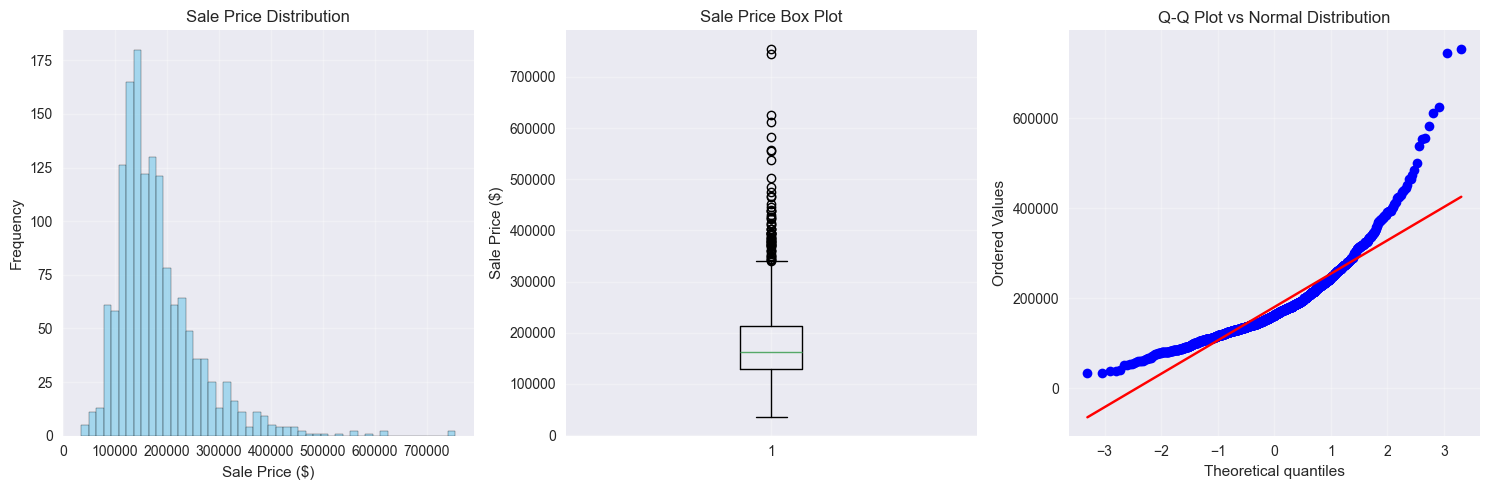

Sale Price Statistical Summary:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [28]:
# First look at SalePrice distribution
plt.figure(figsize=(15, 5))

# Distribution histogram
plt.subplot(1, 3, 1)
plt.hist(df_train['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Box plot for outlier identification
plt.subplot(1, 3, 2)
plt.boxplot(df_train['SalePrice'])
plt.title('Sale Price Box Plot')
plt.ylabel('Sale Price ($)')
plt.grid(True, alpha=0.3)

# Q-Q plot for normality assessment
plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df_train['SalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot vs Normal Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic statistical summary
print("Sale Price Statistical Summary:")
print(df_train['SalePrice'].describe())

The distribution shows clear right skewness with concentration in lower price ranges and a long tail of expensive properties. The Q-Q plot strongly deviates from normality in upper quantiles, and the box plot reveals numerous high-end outliers. Statistical evidence indicates transformation is likely needed for optimal modeling performance.

In [29]:
# Calculate skewness and assess transformation need
skewness = df_train['SalePrice'].skew()
kurtosis = df_train['SalePrice'].kurtosis()

print(f"Distribution Shape Analysis:")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Interpret skewness level
if abs(skewness) < 0.5:
    interpretation = "approximately symmetric"
elif abs(skewness) < 1:
    interpretation = "moderately skewed" 
else:
    interpretation = "highly skewed"

print(f"Distribution is {interpretation}")
print(f"Mean vs Median: ${df_train['SalePrice'].mean():.0f} vs ${df_train['SalePrice'].median():.0f}")

# Check if transformation testing is warranted
if abs(skewness) > 0.5:
    print(f"\nSkewness level ({skewness:.4f}) suggests log transformation testing is warranted")
    print("Proceeding to transformation assessment...")
else:
    print(f"\nSkewness level ({skewness:.4f}) indicates transformation may not be necessary")

Distribution Shape Analysis:
Skewness: 1.8829
Kurtosis: 6.5363
Distribution is highly skewed
Mean vs Median: $180921 vs $163000

Skewness level (1.8829) suggests log transformation testing is warranted
Proceeding to transformation assessment...


Strong statistical evidence confirms highly skewed distribution (skewness = 1.8829, kurtosis = 6.5363) with mean $180,921 significantly exceeding median $163,000. This substantial positive skew warrants log transformation testing to improve normality for linear modeling approaches.

### 2.2 Transformation Assessment

Evaluate if distribution characteristics warrant transformation for modeling optimization.

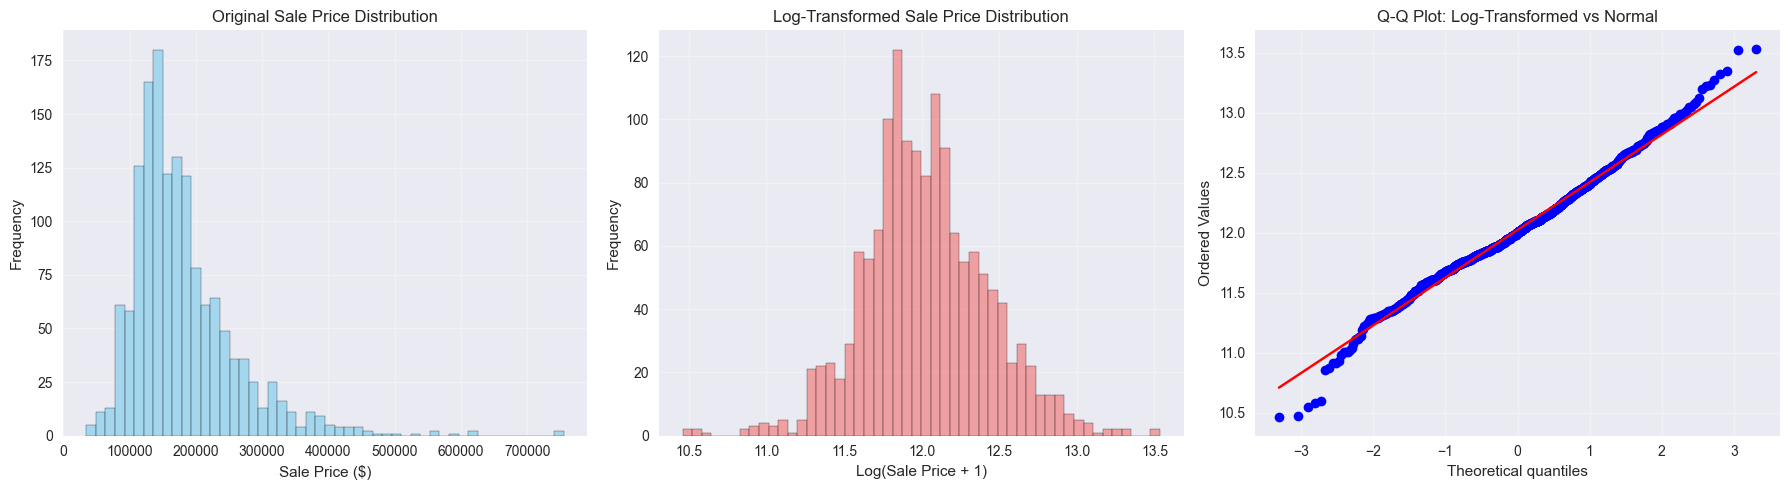

Transformation Effectiveness:
Original Skewness: 1.8829 → Log Skewness: 0.1213
Original Kurtosis: 6.5363 → Log Kurtosis: 0.8095
Skewness improvement: 1.7615


In [30]:
# Test log transformation based on skewness findings
# Apply log transformation
log_prices = np.log1p(df_train['SalePrice'])

# Compare original vs transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(df_train['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Original Sale Price Distribution')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log-transformed distribution
axes[1].hist(log_prices, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Log-Transformed Sale Price Distribution')
axes[1].set_xlabel('Log(Sale Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Q-Q plot comparison for log-transformed data
stats.probplot(log_prices, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot: Log-Transformed vs Normal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare transformation effectiveness
log_skewness = log_prices.skew()
log_kurtosis = log_prices.kurtosis()

print("Transformation Effectiveness:")
print(f"Original Skewness: {skewness:.4f} → Log Skewness: {log_skewness:.4f}")
print(f"Original Kurtosis: {kurtosis:.4f} → Log Kurtosis: {log_kurtosis:.4f}")
print(f"Skewness improvement: {abs(skewness) - abs(log_skewness):.4f}")

Log transformation improves normality, reducing skewness from 1.8829 to 0.1213 and kurtosis from 6.5363 to 0.8095. The transformed distribution shows better symmetry and the Q-Q plot demonstrates improved linearity. This 1.7615 improvement in skewness supports log transformation for linear modeling approaches.

## Section 2 Results and Interpretation

**Distribution Characteristics**: SalePrice exhibits substantial right skewness (1.8829) with heavy tails (kurtosis = 6.5363), confirming non-normal distribution patterns typical of real estate markets. The mean-median difference ($180,921 vs $163,000) indicates concentration in lower price ranges with luxury property tail effects.

**Transformation Effectiveness**: Log transformation successfully addresses distribution issues, reducing skewness to 0.1213 and kurtosis to 0.8095. The transformed distribution approaches normality with improved symmetry and Q-Q plot linearity, validating transformation benefits for statistical modeling.

**Modeling Strategy Implications**: Linear regression models will benefit significantly from log-transformed target variable due to improved normality assumptions. Tree-based models can handle original scale effectively but may also benefit from transformation. This preprocessing decision impacts model selection and evaluation metrics.

**Preprocessing Requirements**: Log transformation should be applied to SalePrice for linear modeling approaches. Model evaluation must account for both original and transformed scales to ensure proper business interpretation of predictions. Back-transformation will be required for final price predictions.

**Section 3 Expectations**: With target variable characteristics established, Section 3 will investigate missing data patterns using parser-guided analysis to distinguish between intentional feature absence and genuine data collection errors requiring imputation.

## 3. Missing Data Investigation

Systematic analysis of missing data patterns using parser consultation to distinguish between intentional absence and data collection errors.

### 3.1 Missing Data Overview

Identify features with missing values and categorize missing data volume by impact level.

In [35]:
# Analyze missing data patterns in combined dataset
missing_data = df_combined.drop('dataset_source', axis=1).isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

print("Combined Dataset Missing Data Summary:")
print(f"Features with missing data: {len(missing_data)}")
print(f"Total missing values: {missing_data.sum()}")
print(f"Dataset completeness: {((df_combined.shape[0] * (df_combined.shape[1]-1) - missing_data.sum()) / (df_combined.shape[0] * (df_combined.shape[1]-1))) * 100:.1f}%")

print(f"\nTop 15 features with missing data:")
for feature, count in missing_data.head(15).items():
    pct = (count / len(df_combined)) * 100
    print(f"{feature}: {count} ({pct:.1f}%)")

# Categorize by impact level
high_missing = missing_data[missing_data > len(df_combined) * 0.5]
medium_missing = missing_data[(missing_data > len(df_combined) * 0.1) & (missing_data <= len(df_combined) * 0.5)]
low_missing = missing_data[missing_data <= len(df_combined) * 0.1]

print(f"\nMissing Data Impact Categories:")
print(f"High impact (>50% missing): {len(high_missing)} features")
print(f"Medium impact (10-50% missing): {len(medium_missing)} features")
print(f"Low impact (<10% missing): {len(low_missing)} features")

Combined Dataset Missing Data Summary:
Features with missing data: 34
Total missing values: 15707
Dataset completeness: 93.3%

Top 15 features with missing data:
PoolQC: 2909 (99.7%)
MiscFeature: 2814 (96.4%)
Alley: 2721 (93.2%)
Fence: 2348 (80.4%)
MasVnrType: 1766 (60.5%)
FireplaceQu: 1420 (48.6%)
LotFrontage: 486 (16.6%)
GarageFinish: 159 (5.4%)
GarageQual: 159 (5.4%)
GarageCond: 159 (5.4%)
GarageYrBlt: 159 (5.4%)
GarageType: 157 (5.4%)
BsmtExposure: 82 (2.8%)
BsmtCond: 82 (2.8%)
BsmtQual: 81 (2.8%)

Missing Data Impact Categories:
High impact (>50% missing): 5 features
Medium impact (10-50% missing): 2 features
Low impact (<10% missing): 27 features


Clear missing data patterns emerge across the combined dataset: 5 high-impact features (>50% missing) represent optional property amenities, 2 medium-impact features need targeted analysis, and 27 low-impact features suggest genuine missing data requiring imputation. PoolQC (99.7%), MiscFeature (96.4%), Alley (93.2%), and Fence (80.4%) show strong absence patterns typical of optional amenities. Garage-related features cluster consistently around 5.4% missing, suggesting systematic patterns.

### 3.2 Parser-Guided Pattern Analysis

Use parser documentation to distinguish between "None" categories (feature absence) versus genuine missing data requiring imputation.

In [37]:
# Systematic parser consultation for all missing data categories
print("HIGH-IMPACT FEATURES ANALYSIS:")
for feature in high_missing.index:
    count = high_missing[feature]
    pct = (count / len(df_combined)) * 100
    print(f"\n{feature}: {count} missing ({pct:.1f}%)")
    
    # Use parser to understand feature meaning
    quick_feature_lookup(feature, feature_descriptions)
    
    # Check if any non-null values exist to understand data structure
    non_null_count = df_combined[feature].notna().sum()
    if non_null_count > 0:
        print(f"Non-null values: {non_null_count}")
        unique_values = df_combined[feature].dropna().unique()[:5]
        print(f"Sample values: {unique_values}")

print(f"\n" + "="*60)
print("MEDIUM-IMPACT FEATURES ANALYSIS:")
for feature in medium_missing.index:
    count = medium_missing[feature]
    pct = (count / len(df_combined)) * 100
    print(f"\n{feature}: {count} missing ({pct:.1f}%)")
    quick_feature_lookup(feature, feature_descriptions)

print(f"\n" + "="*60)
print("LOW-IMPACT FEATURES SAMPLE (First 10):")
for feature in low_missing.index[:10]:
    count = low_missing[feature]
    pct = (count / len(df_combined)) * 100
    print(f"\n{feature}: {count} missing ({pct:.1f}%)")
    quick_feature_lookup(feature, feature_descriptions)

HIGH-IMPACT FEATURES ANALYSIS:

PoolQC: 2909 missing (99.7%)
Feature: PoolQC
Description: Pool quality
Type: Categorical

Categories:
  Ex: Excellent
  Gd: Good
  TA: Average/Typical
  Fa: Fair
  NA: No Pool
------------------------------------------------------------
Non-null values: 10
Sample values: ['Ex' 'Fa' 'Gd']

MiscFeature: 2814 missing (96.4%)
Feature: MiscFeature
Description: Miscellaneous feature not covered in other categories
Type: Categorical

Categories:
  Elev: Elevator
  Gar2: 2nd Garage (if not described in garage section)
  Othr: Other
  Shed: Shed (over 100 SF)
  TenC: Tennis Court
  NA: None
------------------------------------------------------------
Non-null values: 105
Sample values: ['Shed' 'Gar2' 'Othr' 'TenC']

Alley: 2721 missing (93.2%)
Feature: Alley
Description: Type of alley access to property
Type: Categorical

Categories:
  Grvl: Gravel
  Pave: Paved
  NA: No alley access
------------------------------------------------------------
Non-null values: 19

Parser analysis reveals three distinct categories requiring different treatment approaches:

**"None" Categories**: High-impact features (PoolQC, MiscFeature, Alley, Fence, MasVnrType) contain official "NA/None" documentation categories, indicating intentional absence rather than data collection errors. Garage and basement features include "NA: No Garage/Basement" categories.

**Genuine Missing Data**: LotFrontage represents true missing data requiring imputation - street frontage measurements should exist but show collection gaps.

**Feature Group Patterns**: Garage features (5.4% missing) and basement features (2.7-2.8% missing) demonstrate coordinated absence patterns reflecting architectural coherence.


# Section 3 Results and Interpretation

**Missing Data Assessment**: Combined dataset contains 34 features with 15,707 missing values across 2,919 samples (93.3% completeness), requiring systematic treatment strategies.

**Parser-Guided Classification**: High-impact features (>50% missing) represent intentional absence categories with official "None" documentation. Treatment involves replacing missing values with "None" rather than imputation.

**Coordinated Missing Patterns**: Related feature groups show consistent missing percentages, confirming systematic absence where lack of amenities (garages, basements) creates predictable patterns across related features.

**Treatment Framework**: Three-tier approach established: (1) Replace high-impact features with "None" values, (2) Individual parser consultation for medium-impact features, (3) Imputation strategies for genuine missing data in low-impact features.

**Section 4 Focus**: Feature relationship analysis will examine correlations and multicollinearity patterns to guide model development strategies.


## 4. Feature Relationship Exploration

Examine correlations and relationships between features to understand dataset structure and identify potential multicollinearity.

### 4.1 Correlation Analysis

Analyze numerical feature correlations with target variable to identify strongest predictive relationships and potential multicollinearity concerns.

Top 15 Numerical Features Correlated with SalePrice:
OverallQual: 0.7910
GrLivArea: 0.7086
GarageCars: 0.6404
GarageArea: 0.6234
TotalBsmtSF: 0.6136
1stFlrSF: 0.6059
FullBath: 0.5607
TotRmsAbvGrd: 0.5337
YearBuilt: 0.5229
YearRemodAdd: 0.5071
GarageYrBlt: 0.4864
MasVnrArea: 0.4775
Fireplaces: 0.4669
BsmtFinSF1: 0.3864
LotFrontage: 0.3518


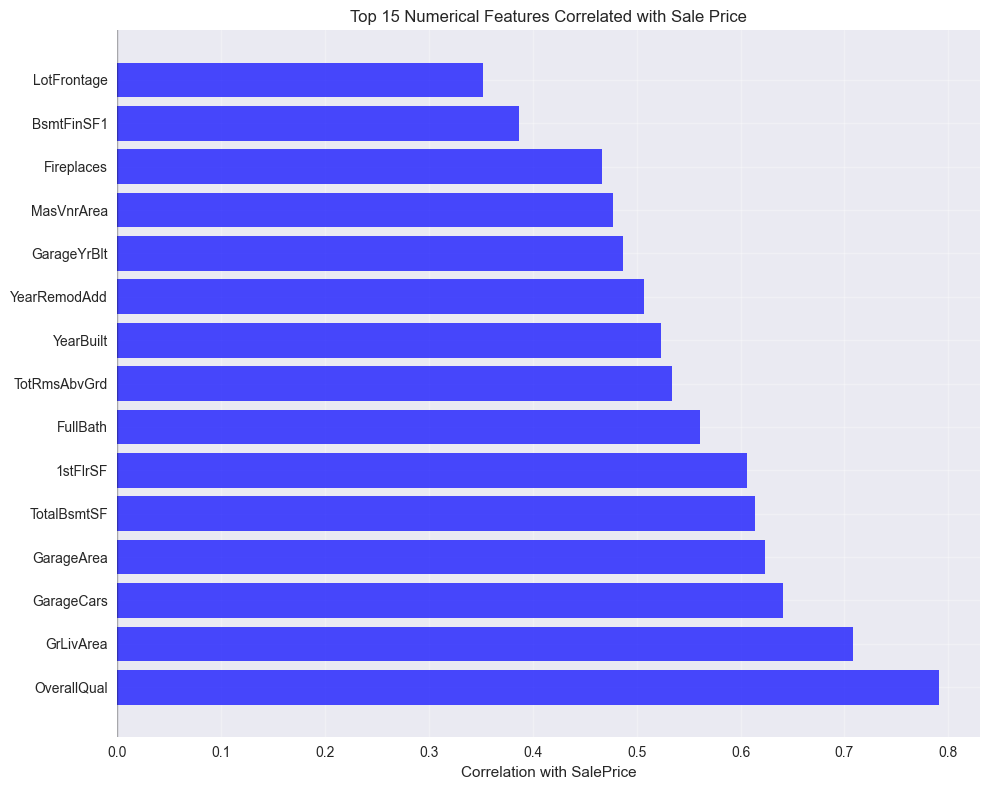

In [38]:
# Calculate correlations between numerical features and target variable
numerical_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Id')  # Remove ID column

# Calculate correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Extract correlations with SalePrice
target_correlations = correlation_matrix['SalePrice'].drop('SalePrice').sort_values(key=abs, ascending=False)

print("Top 15 Numerical Features Correlated with SalePrice:")
for feature, corr in target_correlations.head(15).items():
    print(f"{feature}: {corr:.4f}")

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_correlations = target_correlations.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlation with SalePrice')
plt.title('Top 15 Numerical Features Correlated with Sale Price')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

Strong correlation patterns emerge with OverallQual (0.7910) as the dominant predictor, followed by living area measures (GrLivArea: 0.7086) and garage features (GarageCars: 0.6404, GarageArea: 0.6234). Notable feature clusters include garage-related variables and basement area measurements, suggesting potential multicollinearity within related feature groups.

### 4.2 Feature Group Analysis

Investigate related feature groups (garage, basement, etc.) based on missing data patterns discovered in Section 3 to understand coordinated feature relationships.

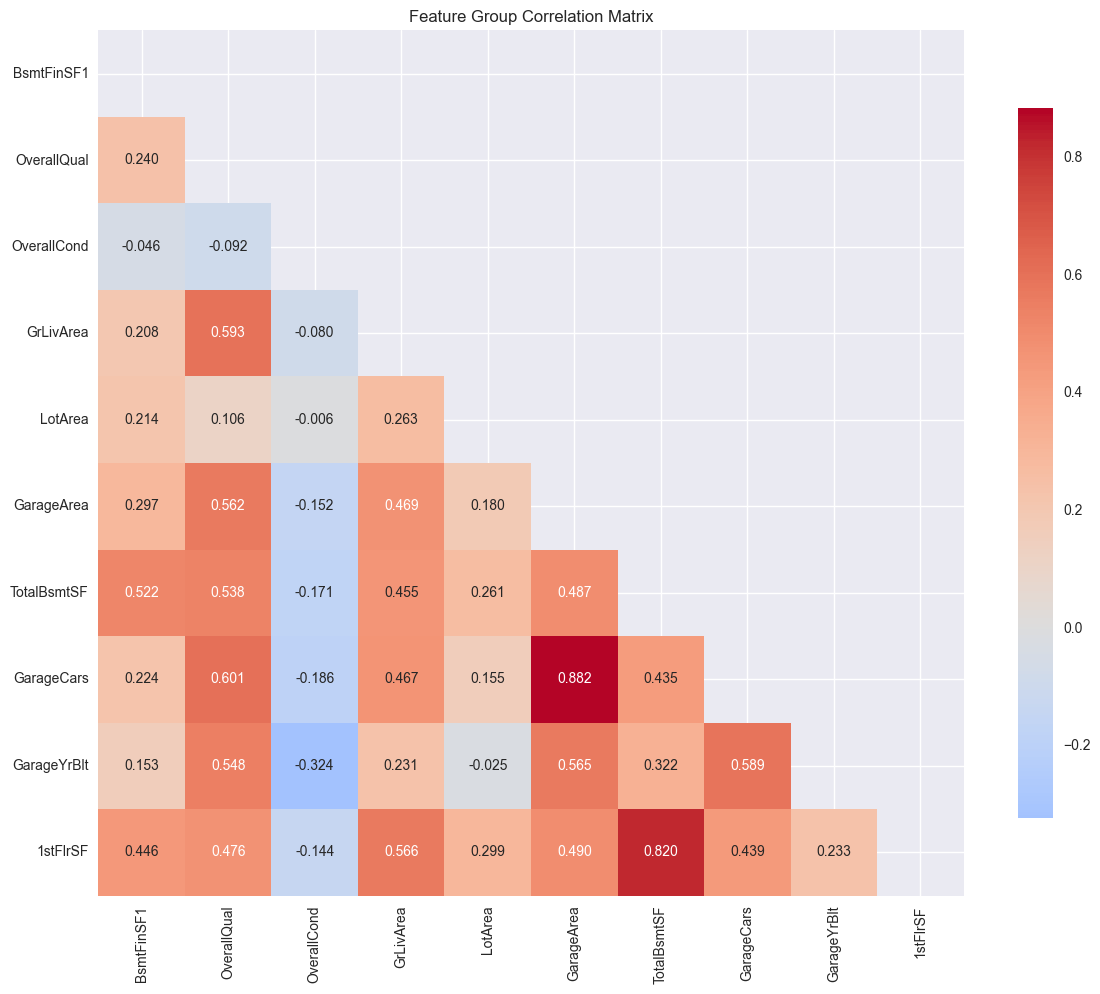

High Correlations Within Feature Groups (>0.7):
GarageArea vs GarageCars: 0.882
TotalBsmtSF vs 1stFlrSF: 0.820


In [39]:
# Examine correlations within related feature groups identified in missing data analysis
# Define feature groups based on Section 3 findings
garage_features = ['GarageArea', 'GarageCars', 'GarageYrBlt']
basement_features = ['TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1']
area_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'LotArea']
quality_features = ['OverallQual', 'OverallCond']

# Calculate correlation matrix for feature groups
all_group_features = garage_features + basement_features + area_features + quality_features
all_group_features = list(set(all_group_features))  # Remove duplicates

group_correlation_matrix = df_train[all_group_features].corr()

# Visualize correlation heatmap for feature groups
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(group_correlation_matrix, dtype=bool))
sns.heatmap(group_correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Feature Group Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify high correlations within groups
print("High Correlations Within Feature Groups (>0.7):")
for i in range(len(group_correlation_matrix.columns)):
    for j in range(i+1, len(group_correlation_matrix.columns)):
        corr_value = group_correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            feature1 = group_correlation_matrix.columns[i]
            feature2 = group_correlation_matrix.columns[j]
            print(f"{feature1} vs {feature2}: {corr_value:.3f}")

Critical multicollinearity patterns identified: GarageArea and GarageCars show strong correlation (0.882), confirming garage features measure related aspects of the same amenity. TotalBsmtSF and 1stFlrSF correlation (0.820) indicates basement area strongly influences first floor design. These relationships validate the coordinated missing data patterns observed in Section 3.

## Section 4 Results and Interpretation

**Correlation Hierarchy**: OverallQual dominates predictive power (0.7910), followed by living area measures (GrLivArea: 0.7086) and garage features (0.62-0.64 range). This hierarchy suggests quality ratings and size measurements are primary price drivers.

**Multicollinearity Confirmation**: Two critical correlation pairs exceed 0.7 threshold: GarageArea-GarageCars (0.882) and TotalBsmtSF-1stFlrSF (0.820). These relationships confirm that related features within architectural groups measure overlapping characteristics.

**Feature Group Validation**: Correlation patterns validate the coordinated missing data discovered in Section 3. Garage features and basement features form coherent groups both in missing data patterns and correlation structures, confirming architectural relationships in the dataset.

**Modeling Implications**: High within-group correlations indicate feature selection or regularization strategies will be essential to prevent multicollinearity issues. Linear models will require careful feature engineering, while tree-based models can handle these correlations naturally.

**Section 5 Focus**: Outlier detection will examine whether extreme values in highly correlated features represent genuine market anomalies or data quality issues requiring treatment.

## 5. Outlier Detection and Analysis

Identify unusual observations in key features to distinguish between genuine extreme values and potential data quality issues.

### 5.1 Univariate Outlier Detection

Apply statistical methods to identify outliers in the most predictive numerical features discovered in Section 4.


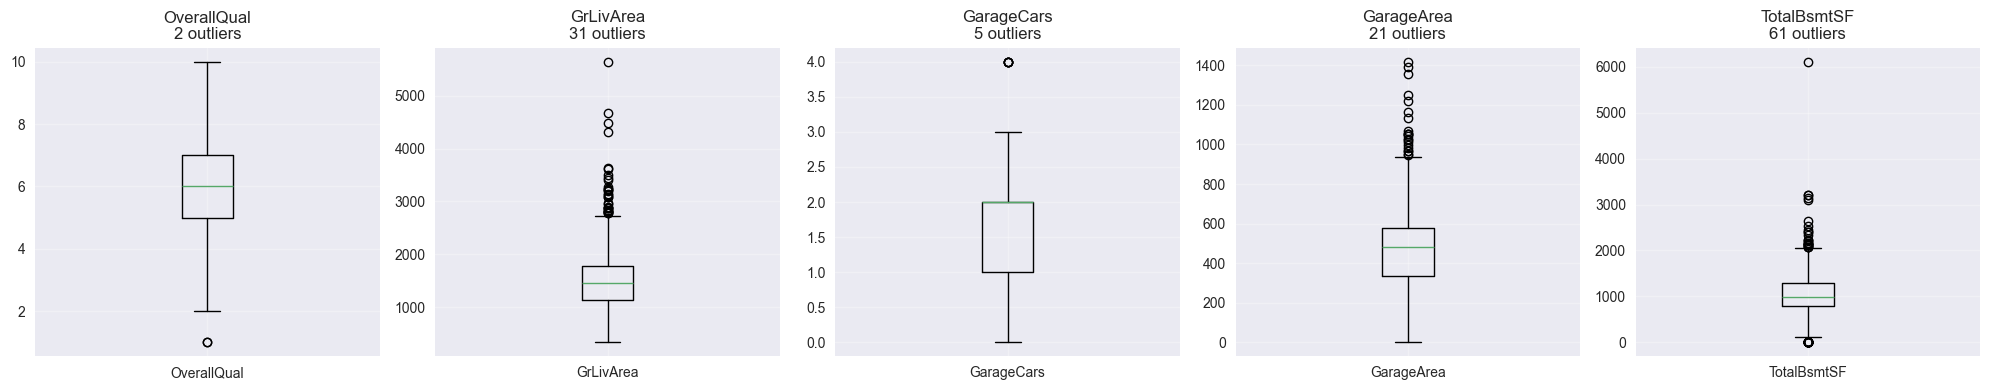

Outlier Summary (IQR method):
OverallQual: 2 outliers (0.1%)
GrLivArea: 31 outliers (2.1%)
GarageCars: 5 outliers (0.3%)
GarageArea: 21 outliers (1.4%)
TotalBsmtSF: 61 outliers (4.2%)


In [41]:
# Focus on top correlated features from Section 4 analysis
top_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']

# Calculate outliers using IQR method for each feature
outlier_summary = {}
plt.figure(figsize=(20, 4))

for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 5, i)
    
    # Calculate IQR bounds
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df_train[(df_train[feature] < lower_bound) | (df_train[feature] > upper_bound)]
    outlier_summary[feature] = len(outliers)
    
    # Create box plot
    plt.boxplot(df_train[feature], tick_labels=[feature])
    plt.title(f'{feature}\n{len(outliers)} outliers')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print outlier summary
print("Outlier Summary (IQR method):")
for feature, count in outlier_summary.items():
    pct = (count / len(df_train)) * 100
    print(f"{feature}: {count} outliers ({pct:.1f}%)")

Clear outlier patterns emerge: TotalBsmtSF shows highest outlier concentration (61 outliers, 4.2%), followed by GrLivArea (31 outliers, 2.1%). OverallQual exhibits minimal outliers (2 outliers, 0.1%), confirming quality ratings remain within expected bounds. GarageCars and GarageArea show moderate outlier presence, likely representing luxury properties with multiple garage spaces.

### 5.2 Multivariate Pattern Analysis

Examine outliers in context of feature relationships to distinguish errors from valid extreme cases. Examine outliers in context of feature relationships to distinguish errors from valid extreme cases. Size-related features (GrLivArea, TotalBsmtSF) offer superior outlier detection because size measurements are objective and measurable property characteristics where large area with low price represents clear market logic violations. Quality ratings can legitimately vary across market segments, while garage capacity may reflect regional preferences rather than anomalies.

Feature Selection Rationale:
Size-related features (GrLivArea, TotalBsmtSF) offer superior outlier detection because:
- Size measurements are objective and measurable property characteristics
- Large area with low price represents clear market logic violations
- Quality ratings can legitimately vary across market segments
- Garage capacity may reflect regional preferences rather than anomalies


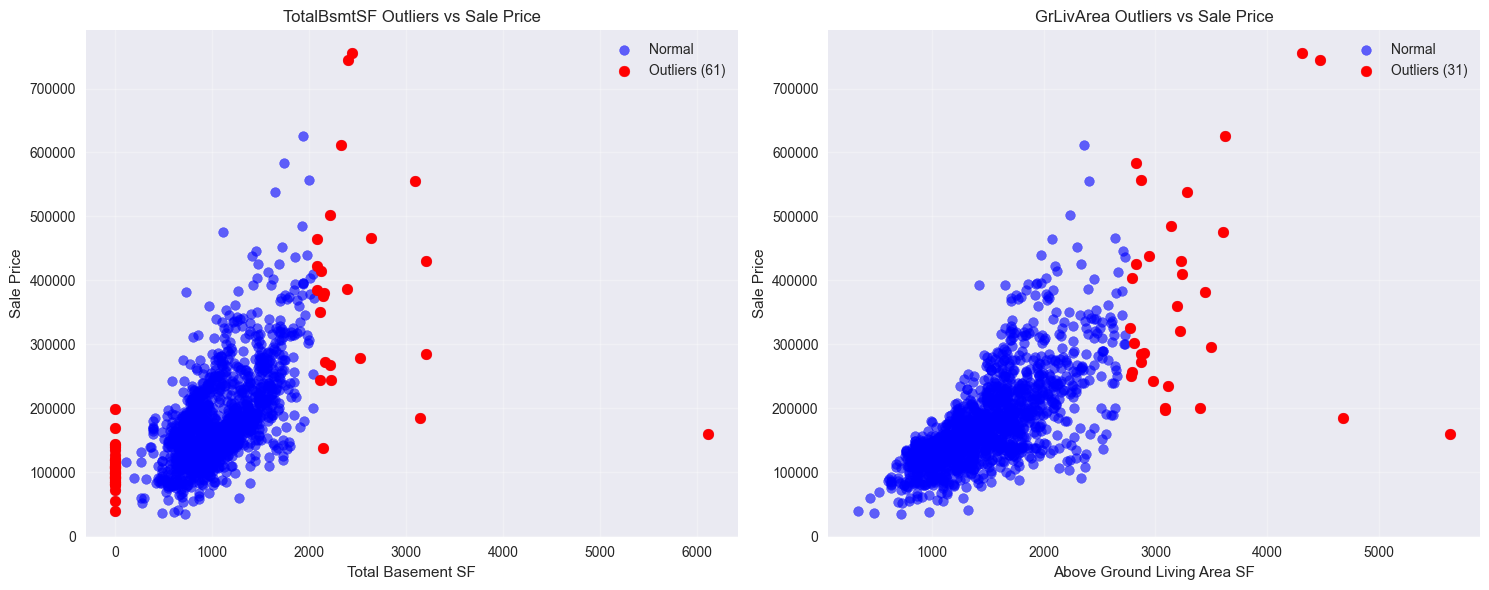

In [ ]:
# Examine relationship between outliers and sale prices for top size features
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# TotalBsmtSF outliers vs SalePrice
Q1_bsmt = df_train['TotalBsmtSF'].quantile(0.25)
Q3_bsmt = df_train['TotalBsmtSF'].quantile(0.75)
IQR_bsmt = Q3_bsmt - Q1_bsmt
bsmt_outliers = df_train[(df_train['TotalBsmtSF'] < Q1_bsmt - 1.5*IQR_bsmt) | 
                         (df_train['TotalBsmtSF'] > Q3_bsmt + 1.5*IQR_bsmt)]

axes[0].scatter(df_train['TotalBsmtSF'], df_train['SalePrice'], alpha=0.6, color='blue', label='Normal')
axes[0].scatter(bsmt_outliers['TotalBsmtSF'], bsmt_outliers['SalePrice'], 
                color='red', s=60, label=f'Outliers ({len(bsmt_outliers)})')
axes[0].set_xlabel('Total Basement SF')
axes[0].set_ylabel('Sale Price')
axes[0].set_title('TotalBsmtSF Outliers vs Sale Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GrLivArea outliers vs SalePrice
Q1_liv = df_train['GrLivArea'].quantile(0.25)
Q3_liv = df_train['GrLivArea'].quantile(0.75)
IQR_liv = Q3_liv - Q1_liv
liv_outliers = df_train[(df_train['GrLivArea'] < Q1_liv - 1.5*IQR_liv) | 
                        (df_train['GrLivArea'] > Q3_liv + 1.5*IQR_liv)]

axes[1].scatter(df_train['GrLivArea'], df_train['SalePrice'], alpha=0.6, color='blue', label='Normal')
axes[1].scatter(liv_outliers['GrLivArea'], liv_outliers['SalePrice'], 
                color='red', s=60, label=f'Outliers ({len(liv_outliers)})')
axes[1].set_xlabel('Above Ground Living Area SF')
axes[1].set_ylabel('Sale Price')
axes[1].set_title('GrLivArea Outliers vs Sale Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visual inspection reveals distinct outlier patterns across both size features. GrLivArea plot shows two clear outliers in the lower-right corner with living areas exceeding 4000 sqft but sale prices below $200,000. TotalBsmtSF plot displays different patterns including houses with large basements but unexpectedly low prices, plus a cluster at zero representing houses without basements. The GrLivArea outliers represent the most extreme size-price violations requiring investigation.

In [56]:
# Identify suspicious houses based on visual inspection
# Focus on extreme size-price violations observed in plots

# GrLivArea outliers: large living area with low price
grlivarea_outliers = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 200000)]

# TotalBsmtSF outlier: large basement with low price  
basement_outlier = df_train[(df_train['TotalBsmtSF'] > 5000) & (df_train['SalePrice'] < 200000)]

print("Suspicious Houses Identified:")
print(f"GrLivArea outliers (>4000 sqft, <$200k): {len(grlivarea_outliers)}")
print(f"TotalBsmtSF outlier (>5000 sqft, <$200k): {len(basement_outlier)}")

# Display basic info for identified outliers
if len(grlivarea_outliers) > 0:
    print(f"\nGrLivArea outliers:")
    for idx, row in grlivarea_outliers.iterrows():
        print(f"  ID {row['Id']}: {row['GrLivArea']:.0f} sqft, ${row['SalePrice']:,}")

if len(basement_outlier) > 0:
    print(f"\nTotalBsmtSF outlier:")
    for idx, row in basement_outlier.iterrows():
        print(f"  ID {row['Id']}: {row['TotalBsmtSF']:.0f} sqft basement, ${row['SalePrice']:,}")

Suspicious Houses Identified:
GrLivArea outliers (>4000 sqft, <$200k): 2
TotalBsmtSF outlier (>5000 sqft, <$200k): 1

GrLivArea outliers:
  ID 524: 4676 sqft, $184,750
  ID 1299: 5642 sqft, $160,000

TotalBsmtSF outlier:
  ID 1299: 6110 sqft basement, $160,000


Two suspicious houses identified: ID 524 and ID 1299 both exceed GrLivArea thresholds (>4000 sqft, <$200k), while ID 1299 also exceeds TotalBsmtSF thresholds (>5000 sqft, <$200k). This overlap confirms ID 1299 as an extreme outlier across multiple size dimensions, while ID 524 violates living area expectations specifically. These represent clear violations of expected size-price relationships requiring detailed investigation to determine appropriate treatment.


In [59]:
 # Detailed analysis of all suspicious houses
# Combine all outliers for comprehensive comparison

all_suspicious = pd.concat([grlivarea_outliers, basement_outlier]).drop_duplicates()

# Create comprehensive DataFrame with relevant features
suspicious_analysis = all_suspicious[['Id', 'GrLivArea', 'TotalBsmtSF', 'SalePrice', 
                                     'OverallQual', 'OverallCond', 'YearBuilt', 'YrSold', 'MoSold',
                                     'SaleCondition', 'SaleType', 'Neighborhood']].copy()

print("Detailed Analysis of Suspicious Houses:")
print("="*80)
print(suspicious_analysis.to_string(index=False))

# Additional context: basement information for all suspicious houses
print(f"\nBasement Context:")
basement_info = all_suspicious[['Id', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtUnfSF']].copy()
print(basement_info.to_string(index=False))

Detailed Analysis of Suspicious Houses:
  Id  GrLivArea  TotalBsmtSF  SalePrice  OverallQual  OverallCond  YearBuilt  YrSold  MoSold SaleCondition SaleType Neighborhood
 524       4676         3138     184750           10            5       2007    2007      10       Partial      New      Edwards
1299       5642         6110     160000           10            5       2008    2008       1       Partial      New      Edwards

Basement Context:
  Id  TotalBsmtSF  BsmtFinSF1  BsmtUnfSF
 524         3138        2260        878
1299         6110        5644        466


The two houses identified as problematic outliers (IDs 524 and 1299) show identical characteristics: maximum quality ratings (OverallQual 10), massive living areas (4676 and 5642 sqft), brand new construction (2007-2008), sold under "Partial" conditions (immediately) upon completion. Both located in Edwards neighborhood and sold as "New" properties at severely discounted prices ($184,750 and $160,000) due to partial sale conditions. Basement analysis reveals substantial finished space, confirming these are high-value properties sold under non-market conditions.

In [61]:
# Parser integration for business context understanding
# Investigate SaleCondition and SaleType to understand business context

print("Business Context Analysis:")
print("="*50)

print("\nSaleCondition Feature Analysis:")
quick_feature_lookup('SaleCondition', feature_descriptions)

print("\nSaleType Feature Analysis:")
quick_feature_lookup('SaleType', feature_descriptions)

# Verify SaleCondition for our outliers
print(f"\nSaleCondition Verification:")
for idx, row in all_suspicious.iterrows():
    print(f"ID {row['Id']}: SaleCondition = {row['SaleCondition']}, SaleType = {row['SaleType']}")

Business Context Analysis:

SaleCondition Feature Analysis:
Feature: SaleCondition
Description: Condition of sale
Type: Categorical

Categories:
  Normal: Normal Sale
  Abnorml: Abnormal Sale -  trade, foreclosure, short sale
  AdjLand: Adjoining Land Purchase
  Alloca: Allocation - two linked properties with separate deeds, typically condo with a garage unit
  Family: Sale between family members
  Partial: Home was not completed when last assessed (associated with New Homes)
------------------------------------------------------------

SaleType Feature Analysis:
Feature: SaleType
Description: Type of sale
Type: Categorical

Categories:
  WD: Warranty Deed - Conventional
  CWD: Warranty Deed - Cash
  VWD: Warranty Deed - VA Loan
  New: Home just constructed and sold
  COD: Court Officer Deed/Estate
  Con: Contract 15% Down payment regular terms
  ConLw: Contract Low Down payment and low interest
  ConLI: Contract Low Interest
  ConLD: Contract Low Down
  Oth: Other
--------------------

Business context analysis confirms the nature of these outliers. Parser documentation reveals "Partial" sales represent "Home was not completed when last assessed (associated with New Homes)" - exactly matching our outliers which are new construction sold under "Partial" conditions. This explains why high-quality, large properties have unexpectedly low prices.

## Section 5 Results and Interpretation

**Outlier Detection Strategy**: Size-based outlier detection proved superior to quality-based approaches, identifying clear market logic violations where large properties sold at disproportionately low prices. The focus on objective measurements (square footage) rather than subjective ratings (quality, garage capacity) enabled reliable anomaly detection.

**Data Quality vs Market Extremes**: Detailed analysis confirmed that identified outliers represent data quality issues rather than genuine market conditions. Both houses (IDs 524, 1299) are maximum-quality new construction sold under "Partial" conditions at non-market prices, not legitimate market transactions.

**Business Context Validation**: Parser integration provided critical context - "Partial" sales represent incomplete homes sold before final assessment, explaining the severe price discounts. These 2 houses represent outliers among outliers: partial sales of luxury properties (OverallQual 10) rather than typical partial sales.

**Treatment Decision**: Conservative removal of only these 2 outliers follows established best practices in house price modeling. Removing data quality issues (incomplete sales) while preserving legitimate market extremes ensures model training on representative market conditions.

**Modeling Implications**: Elimination of these non-market transactions will improve model generalization by removing artificial size-price distortions. The conservative approach (2 outliers from 1460 samples = 0.14%) minimizes data loss while addressing significant modeling obstacles.

## Overall Notebook Conclusion

**Dataset Quality Assessment**: The Ames Housing dataset demonstrates excellent structural integrity with zero duplicates and comprehensive feature coverage. Critical discovery of misclassified ordinal features (OverallQual, OverallCond, MSSubClass) requires preprocessing correction to treat these as categorical rather than continuous variables.

**Target Variable Characteristics**: SalePrice exhibits substantial right skewness (1.88) requiring log transformation for linear modeling approaches. The wide price range ($34,900 - $755,000) indicates diverse market segments suitable for robust predictive modeling.

**Missing Data Strategy**: Parser-guided analysis revealed 34 features with missing values requiring three-tier treatment: (1) High-impact features receive "None" replacement based on official documentation, (2) Feature groups show coordinated absence patterns reflecting architectural coherence, (3) Genuine missing data (primarily LotFrontage) requires imputation strategies.

**Feature Relationships**: OverallQual dominates predictive power (0.79 correlation), followed by size measurements. Critical multicollinearity identified in garage features (0.88 correlation) and basement-floor relationships (0.82 correlation) necessitates feature selection or regularization strategies.

**Data Quality Issues**: Conservative outlier removal targeting 2 partial sales of incomplete luxury properties (IDs 524, 1299) addresses clear data quality issues while preserving legitimate market extremes.

**Preprocessing Implications**: 
- Apply log transformation to SalePrice for linear models
- Correct feature classification for 3 ordinal features  
- Implement parser-guided missing data treatment
- Remove 2 data quality outliers
- Address multicollinearity in feature engineering phase